# GAN for Cat and Dog images - grey-scaled version

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

## Load in the dataset

In [ ]:
!pip install -q kaggle                         # -q to keep output clean
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json              # restrict permissionsb

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 96% 779M/812M [00:04<00:00, 40.9MB/s]
100% 812M/812M [00:04<00:00, 194MB/s] 


In [ ]:
!unzip /content/dogs-vs-cats.zip

Archive:  /content/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip /content/train.zip

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(32, 32)),
    transforms.Grayscale(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, path, transform, exts=(".jpg")):
        self.dir  = Path(path)
        self.transform = transform
        pattern        = "*"
        self.paths     = [p for p in self.dir.glob(pattern) if p.suffix.lower() in exts]
        if len(self.paths) == 0:
            raise RuntimeError(f"No images found in {self.dir}")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [ ]:
# Load in the data and convert them into a dataset
true_dataset = CatDogDataset("/content/train/", transform)
true_loader = DataLoader(true_dataset, batch_size=128)

In [ ]:
def rescaled_images(imgs):
    # Scale the value back to [0,1] range
    imgs = (imgs + 1) / 2
    return imgs

## Build the model (Deep Convolutional GAN)

In [ ]:
class DCGenerator(nn.Module):
    """
    The cat/dog image generator for the GAN.
    Note that `latent_dims` is expected to be a tuple of 2 integers
    The output_sizes must be a tuple of two integers H by W.

    This generator will create images with 3 color channels.
    """
    def __init__(self, latent_dims, output_sizes):
        super(DCGenerator, self).__init__()
        assert len(latent_dims) == 2

        self.latent_dims = latent_dims
        self.output_sizes = output_sizes
        num_pixels = np.prod(output_sizes).item()

        # Dense layer to map latent data to image's size
        self.fc = nn.Sequential(
            nn.Linear(np.prod(self.latent_dims).item(), 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, num_pixels),
            nn.Tanh()
        )

    def forward(self, X):
        # Flatten the data
        X = X.view(X.size(0), -1)
        outs = self.fc(X)
        # Reshape the output
        outs = outs.view(X.size(0), 1, *self.output_sizes)
        return outs

In [ ]:
class DCDiscriminator(nn.Module):
    """
    Expect the 3 color channel images
    """
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, X):
        outs = self.fc(X.view(X.size(0), -1))
        return outs

In [ ]:
def configure(D, G, device, lr=0.0002):
    D.to(device)
    G.to(device)
    criterion = nn.BCEWithLogitsLoss()
    d_optim = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.99))
    g_optim = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.99))
    return criterion, d_optim, g_optim

In [ ]:
def train_GAN(D, G, criterion, d_optim, g_optim, device, true_loader, num_epochs, gen_iters):
    d_history = np.zeros(num_epochs)
    g_history = np.zeros(num_epochs)

    # Labels for convenience
    reals = torch.ones(128).to(device)
    fakes = torch.zeros(128).to(device)

    for epoch in range(num_epochs):
        d_loss_epoch = []
        g_loss_epoch = []
        for inputs in true_loader:
            n = len(inputs)
            inputs = inputs.to(device)

            ''' Train discriminator '''
            # Create fake images
            latent_data = torch.randn((n, 13, 13)).to(device)
            outs = G(latent_data)
            outs = D(outs)
            d_loss_fake = criterion(outs, fakes[:n].view(-1, 1))
            d_loss_real = criterion(D(inputs), reals[:n].view(-1, 1))

            d_loss = (d_loss_fake + d_loss_real) / 2
            d_optim.zero_grad()
            g_optim.zero_grad()
            d_loss.backward()
            d_optim.step()
            d_loss_epoch.append(d_loss.item())

            '''Train generator'''
            for i in range(gen_iters):
                # Create fake images
                latent_data = torch.randn((n, 13, 13)).to(device)
                outs = G(latent_data)
                outs = D(outs)
                g_loss = criterion(outs, reals[:n].view(-1, 1))
                d_optim.zero_grad()
                g_optim.zero_grad()
                g_loss.backward()
                g_optim.step()
                g_loss_epoch.append(g_loss.item())

        d_history[epoch] = np.mean(d_loss_epoch).item()
        g_history[epoch] = np.mean(g_loss_epoch).item()

        print(f"Epoch: {epoch}")

        # Generate some fake images to examine
        if epoch % 50:
            latent_data = torch.randn((128, 13, 13)).to(device)
            imgs = G(latent_data)
            save_image(rescaled_images(imgs), f"./images/cat_dog_grey/{epoch}.png")

    return d_history, g_history

## Train the model

In [ ]:
# Some hyperparameters
num_epochs = 50
latent_dims = (13, 13)
output_sizes = (32, 32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gen_iters = 2

In [ ]:
D = DCDiscriminator()
G = DCGenerator(latent_dims, output_sizes)
criterion, d_optim, g_optim = configure(D, G, device)

In [ ]:
from time import perf_counter

In [ ]:
start = perf_counter()
d_history, g_history = train_GAN(D, G, criterion, d_optim, g_optim, device,
                                true_loader, num_epochs, gen_iters)
end = perf_counter()
f"Need {end - start:.4f}s"

Epoch: 0
Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Epoch: 30
Epoch: 30
Epoch: 35
Epoch: 35
Epoch: 40
Epoch: 40
Epoch: 45
Epoch: 45


'Need 8787.9995s'

'Need 8787.9995s'

## Evaluate the models

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

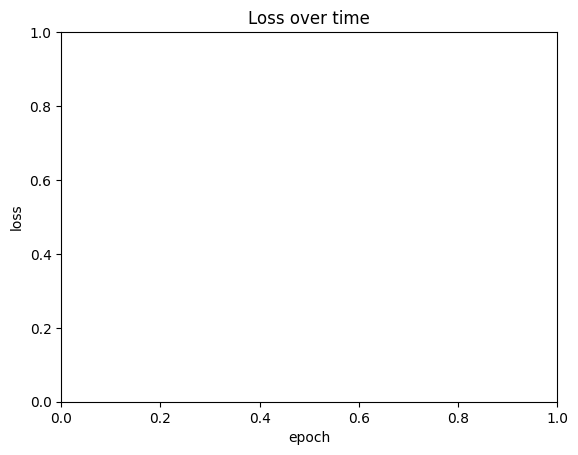

In [ ]:
plt.title("Loss over time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(d_history, label="discriminator")
plt.plot(g_history, label="generator")
plt.legend()
plt.show()

Examine some generated images through time

In [ ]:
from skimage.io import imread

In [ ]:
img1 = imread("./images/cat_dog/1.png")
img2 = imread("./images/cat_dog/5.png")
img3 = imread("./images/cat_dog/20.png")
img4 = imread("./images/cat_dog/35.png")
img5 = imread("./images/cat_dog/45.png")

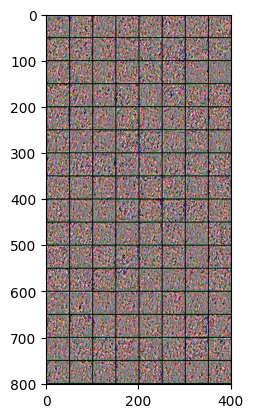

In [ ]:
plt.imshow(img1)

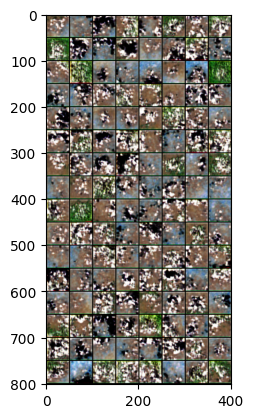

In [ ]:
plt.imshow(img2)

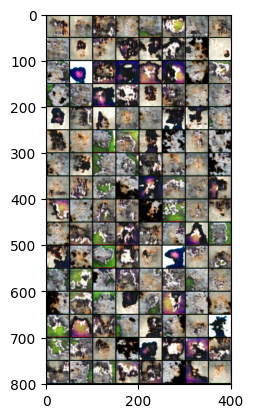

In [ ]:
plt.imshow(img3)

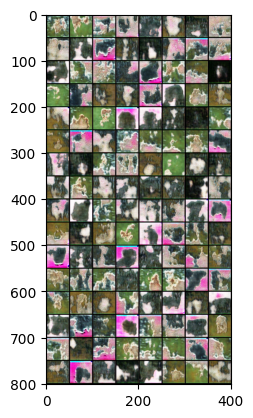

In [ ]:
plt.imshow(img4)

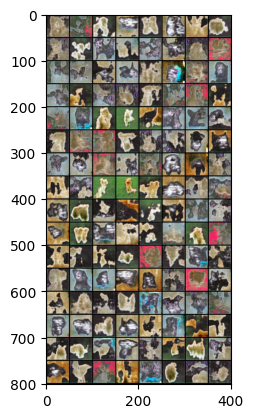

In [ ]:
plt.imshow(img5)

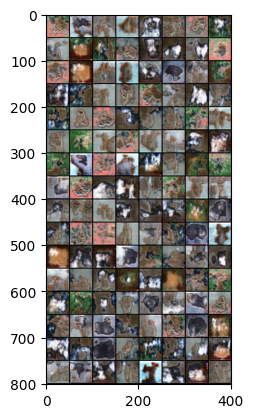

In [ ]:
latent_data = torch.randn((128, 13, 13)).to(device)
outs = G(latent_data)
save_image(rescaled_images(outs), "./images/cat_dog/final.png")
img6 = imread("./images/cat_dog/final.png")
plt.imshow(img6)

We can see that from far away, the model did pick up something about the patterns of dogs/cats. However, if we zoom in, we can see that the generated images are still very poor. One reason behind this is that I only trained the model for 50 epochs. Another reason is that I use 3 color channels, which may make it hard for the model to learn the pattern in short amount of time. 